WNixalo | 20181121

---

The purpose of this notebook is to make sure I'm not going crazy and that there isn't some breaking change with the update to fastai. I trained a model and got scores between 0.2 to 0.5, even though f_beta indicated +0.93. Here's running a quick and simple baseline by following the code in the course's lesson3 notebook.

In [64]:
__version__ # fastai version

'1.0.28'

In [11]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [12]:
from fastai import *
from fastai.vision import *

## Data

In [13]:
path = Config.data_path()/'planet'
path.mkdir(exist_ok=True)
path

PosixPath('/home/jupyter/.fastai/data/planet')

In [14]:
df = pd.read_csv(path/'train_v2.csv')

In [15]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [16]:
# np.random.seed(0)

In [17]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

np.random.seed(0)
src = (ImageItemList.from_csv(path, 'train_v2.csv', folder='train-jpg', suffix='.jpg')
       .random_split_by_pct(0.2)
       .label_from_df(sep=' '))

data = (src.transform(tfms, size=128)
        .databunch().normalize(imagenet_stats))

In [ ]:
# data.show_batch(rows=3, figsize=(10,10))

## MultiClass

In [18]:
arch = models.resnet34

In [19]:
acc_025 = partial(accuracy_thresh, thresh=0.25)
f_score = partial(fbeta, thresh=0.25)
learn   = create_cnn(data, arch, metrics=[acc_025, f_score])

### Stage 1 size 128

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


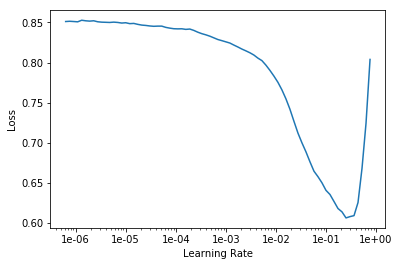

In [20]:
learn.lr_find()
learn.recorder.plot()

In [21]:
lr = 0.01

In [22]:
learn.fit_one_cycle(5, slice(lr))

Total time: 04:38
epoch  train_loss  valid_loss  accuracy_thresh  fbeta   
1      0.120202    0.107641    0.954169         0.903770  (01:01)
2      0.110489    0.099101    0.955346         0.910184  (00:54)
3      0.106647    0.096185    0.959256         0.912535  (00:54)
4      0.097307    0.089358    0.959431         0.920518  (00:54)
5      0.092675    0.087718    0.959714         0.922585  (00:54)



### Stage 2 size 128

In [23]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


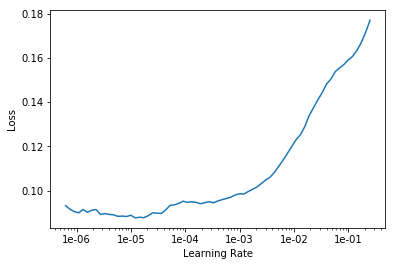

In [24]:
learn.lr_find()
learn.recorder.plot()

In [25]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

Total time: 06:33
epoch  train_loss  valid_loss  accuracy_thresh  fbeta   
1      0.096587    0.093046    0.958478         0.918083  (01:19)
2      0.098384    0.091206    0.960150         0.921171  (01:18)
3      0.090742    0.087751    0.961036         0.922196  (01:18)
4      0.090385    0.084658    0.961327         0.926245  (01:18)
5      0.084263    0.084057    0.962119         0.925713  (01:18)



### Stage 1 size 256

In [28]:
data = (src.transform(tfms, size=256)
        .databunch().normalize(imagenet_stats))

learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 256, 256])

In [29]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


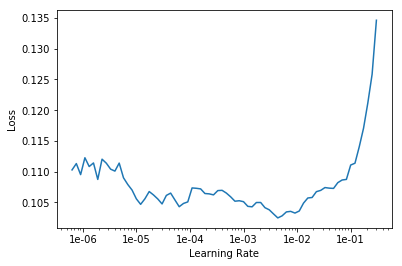

In [30]:
learn.lr_find()
learn.recorder.plot()

In [31]:
lr = 1e-2/2

In [32]:
learn.fit_one_cycle(5, slice(lr))

Total time: 15:05
epoch  train_loss  valid_loss  accuracy_thresh  fbeta   
1      0.088716    0.084877    0.962671         0.925561  (03:01)
2      0.089203    0.086505    0.957207         0.923841  (03:01)
3      0.088201    0.084113    0.962504         0.927339  (03:00)
4      0.085385    0.082428    0.963848         0.928919  (03:00)
5      0.082733    0.081689    0.963456         0.928592  (03:00)



### Stage 2 size 256

In [33]:
learn.unfreeze()

In [34]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

Total time: 20:30
epoch  train_loss  valid_loss  accuracy_thresh  fbeta   
1      0.084788    0.083974    0.960353         0.926236  (04:05)
2      0.088320    0.085459    0.961204         0.925216  (04:09)
3      0.084728    0.083833    0.962221         0.924758  (04:05)
4      0.081390    0.081551    0.962352         0.926804  (04:05)
5      0.079002    0.080909    0.963558         0.928479  (04:05)



## Test set

In [ ]:
# learn.load('stage-2-256-rn34_1') # extra training
# learn.load('stage-2-256-rn34')

In [35]:
idx2class = idx2class = {v:k for k,v in learn.data.train_ds.y.c2i.items()}

In [36]:
idx2class

{0: 'artisinal_mine',
 1: 'clear',
 2: 'agriculture',
 3: 'blooming',
 4: 'primary',
 5: 'cultivation',
 6: 'conventional_mine',
 7: 'slash_burn',
 8: 'selective_logging',
 9: 'habitation',
 10: 'water',
 11: 'partly_cloudy',
 12: 'road',
 13: 'haze',
 14: 'bare_ground',
 15: 'blow_down',
 16: 'cloudy'}

In [37]:
subm_df = pd.read_csv(path/'sample_submission_v2.csv')
subdic = {c1:c2 for c1,c2 in zip(subm_df.image_name,subm_df.tags)}

In [42]:
def set_test_datafolder(learner, test_folder):
    learner.data = (src.add_test_folder(test_folder)
                    .transform(tfms, size=256)
                    .databunch().normalize(imagenet_stats))

1st dataset portion

In [43]:
set_test_datafolder(learn, 'test-jpg')
raw_preds = learn.TTA(ds_type=DatasetType.Test)

Total time: 12:08



In [44]:
len(raw_preds), raw_preds[0].shape, raw_preds[1].shape

(2, torch.Size([40669, 17]), torch.Size([40669, 17]))

In [45]:
preds = copy(raw_preds)

In [46]:
fnames = [f.name.split('.')[0] for f in learn.data.test_ds.x.items]

2nd dataset portion

In [48]:
set_test_datafolder(learn, 'test-jpg-additional')
raw_preds = learn.TTA(ds_type=DatasetType.Test)

Total time: 06:13



In [49]:
preds = (torch.cat((preds[0],raw_preds[0])), torch.cat((preds[1],raw_preds[1])))

In [50]:
fnames.extend([f.name.split('.')[0] for f in learn.data.test_ds.x.items])

In [58]:
# raw_preds = learn.get_preds(ds_type=DatasetType.Test)

/opt/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1124: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


## Submitting predictions to Kaggle

In [61]:
import datetime
date = str(datetime.date.today()).replace('-','')

In [62]:
th = 0.3

for i,fn in enumerate(fnames):
    subdic[fn] = ' '.join(idx2class[cdx] for cdx in np.where(preds[0][i]>=th)[0])
    
subm_col = [subdic[fn] for fn in subm_df.image_name]
subm_df.tags = subm_col

In [63]:
sub_name = f'planet_stage-2-256-rn34_{date}_th{str(th)}.csv'
subm_df.to_csv(path/'submissions/'/sub_name, index=False, )
! kaggle competitions submit -c planet-understanding-the-amazon-from-space -f {path}/submissions/{sub_name} -m "fastai 1.0.28; 2-stg; RN34; threshold="{th}

100%|██████████████████████████████████████| 2.06M/2.06M [00:00<00:00, 2.35MB/s]
Successfully submitted to Planet: Understanding the Amazon from Space

Threshold of 0.3 got a private score of 0.92225, so I'm not going crazy, and no breaking change was introduced with the update fastai. Looks like I could've made any of a dozen little mistakes, and judging by the amount of little random errors and 'huh.. why is it *that* way, that's *odd*''s... that's very likely.

In [ ]:
# prob = preds[0][1]
# pred = preds[1][1]

In [ ]:
# for i in zip(prob, pred): print(i)

In [ ]:
# temp = []

In [ ]:
# for i in range(len(preds[1])):
#     for j in range(len(preds[1][i])):
#         if preds[1][i][j]==1: temp.append(j)

In [ ]:
# np.unique(np.array(temp))

## end